In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])

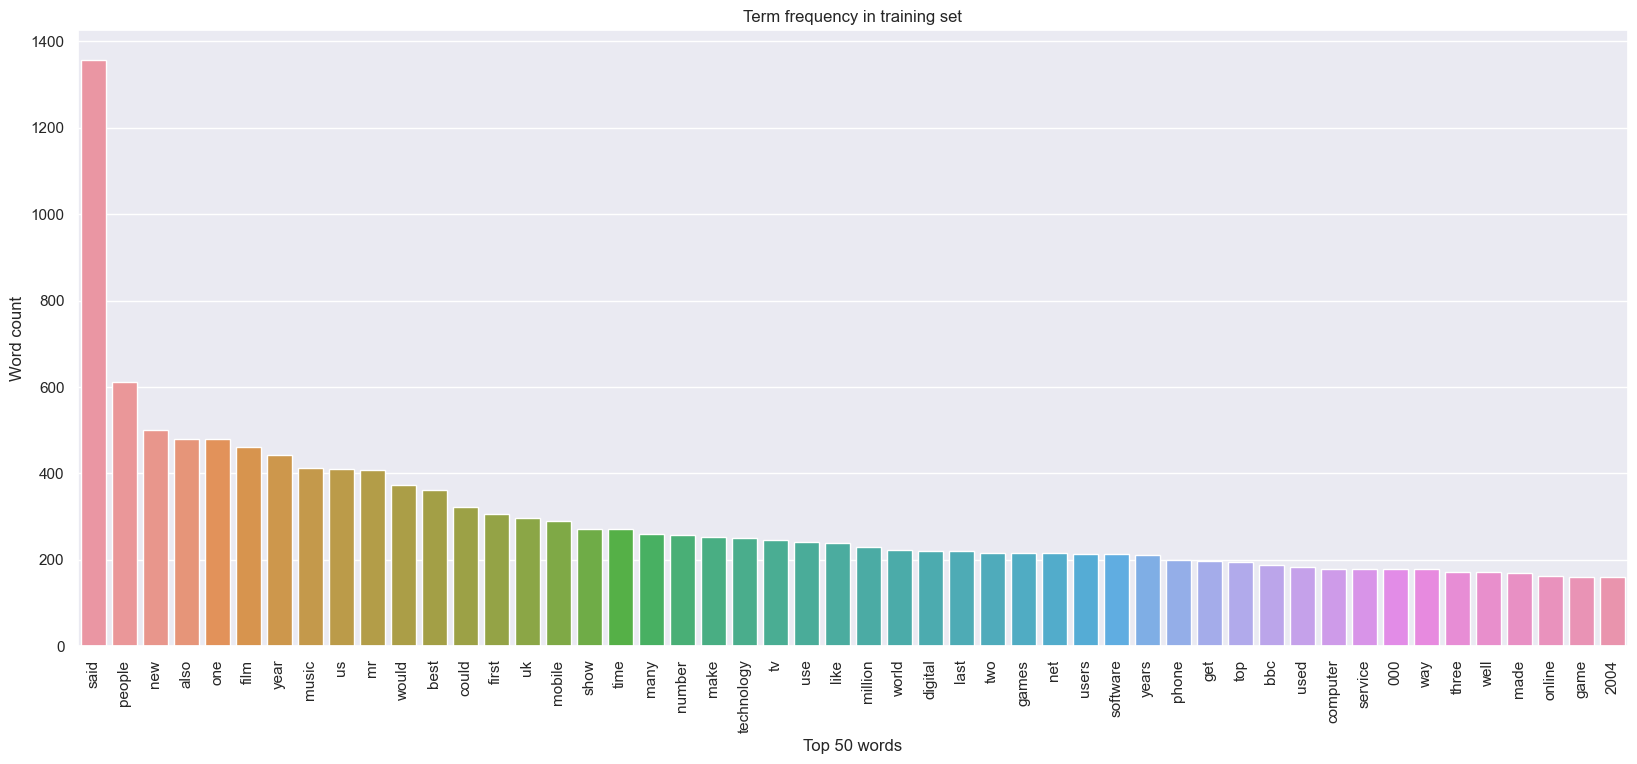

In [2]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)
#print(prep_X_count)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

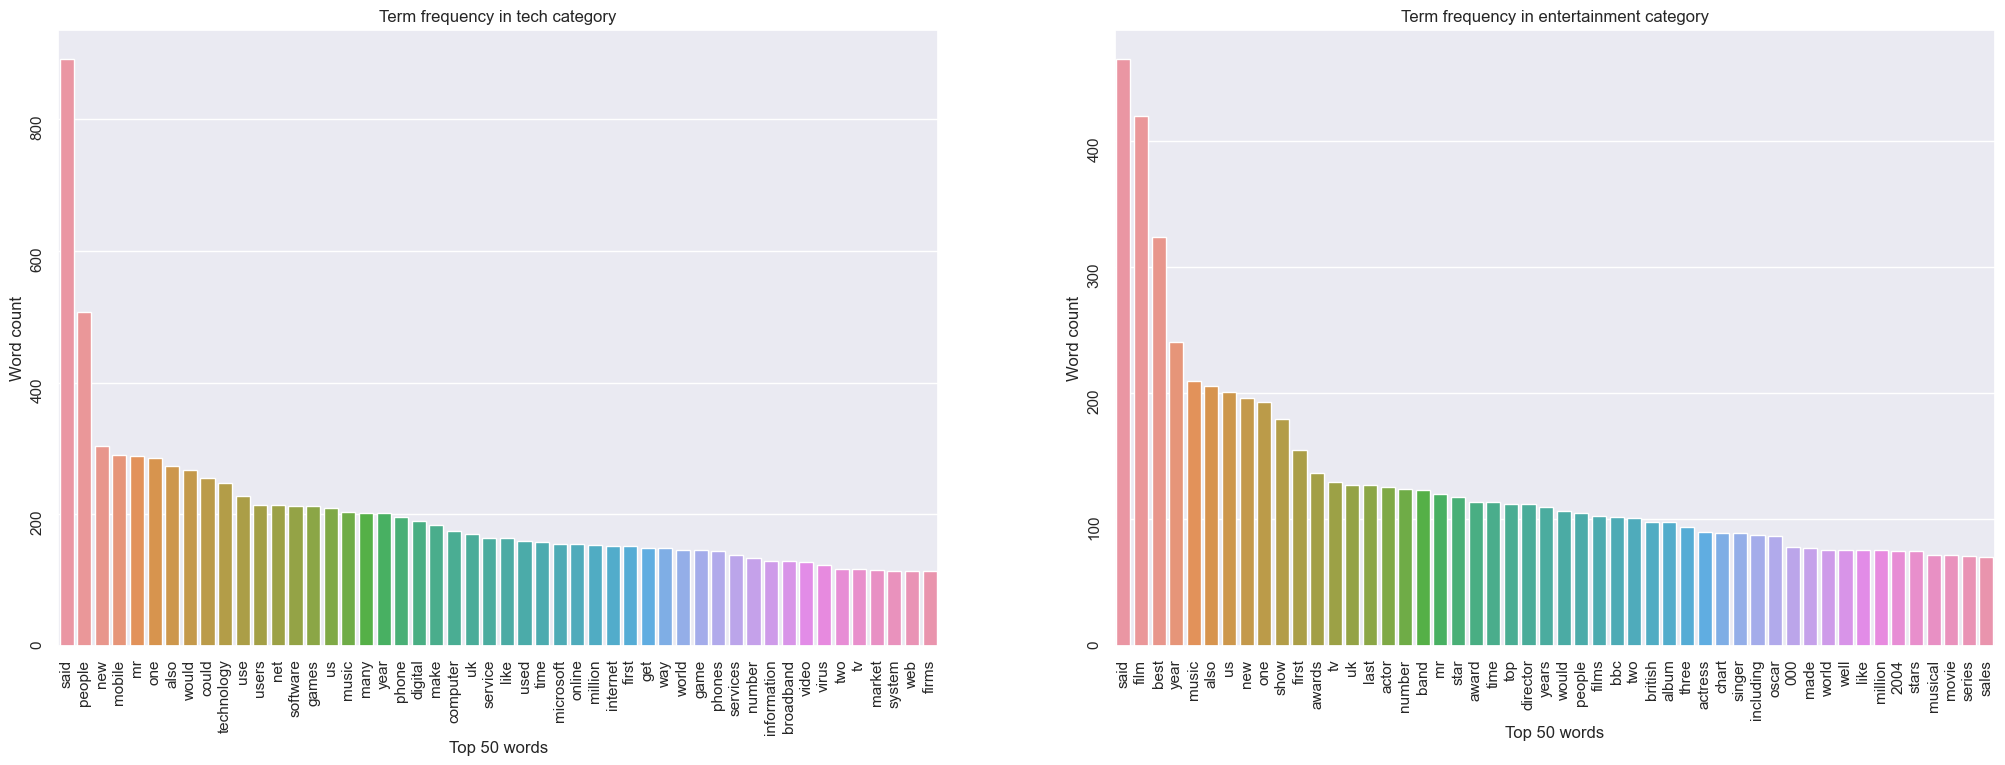

In [3]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

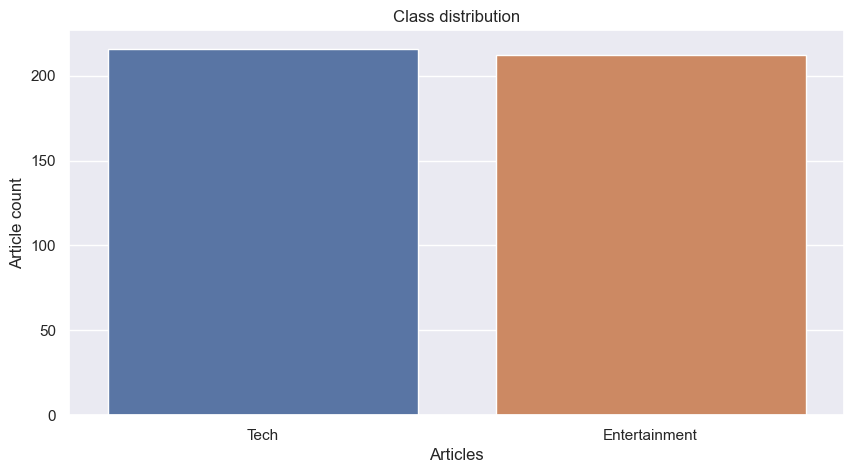

In [4]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [5]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Task 2b) kNN

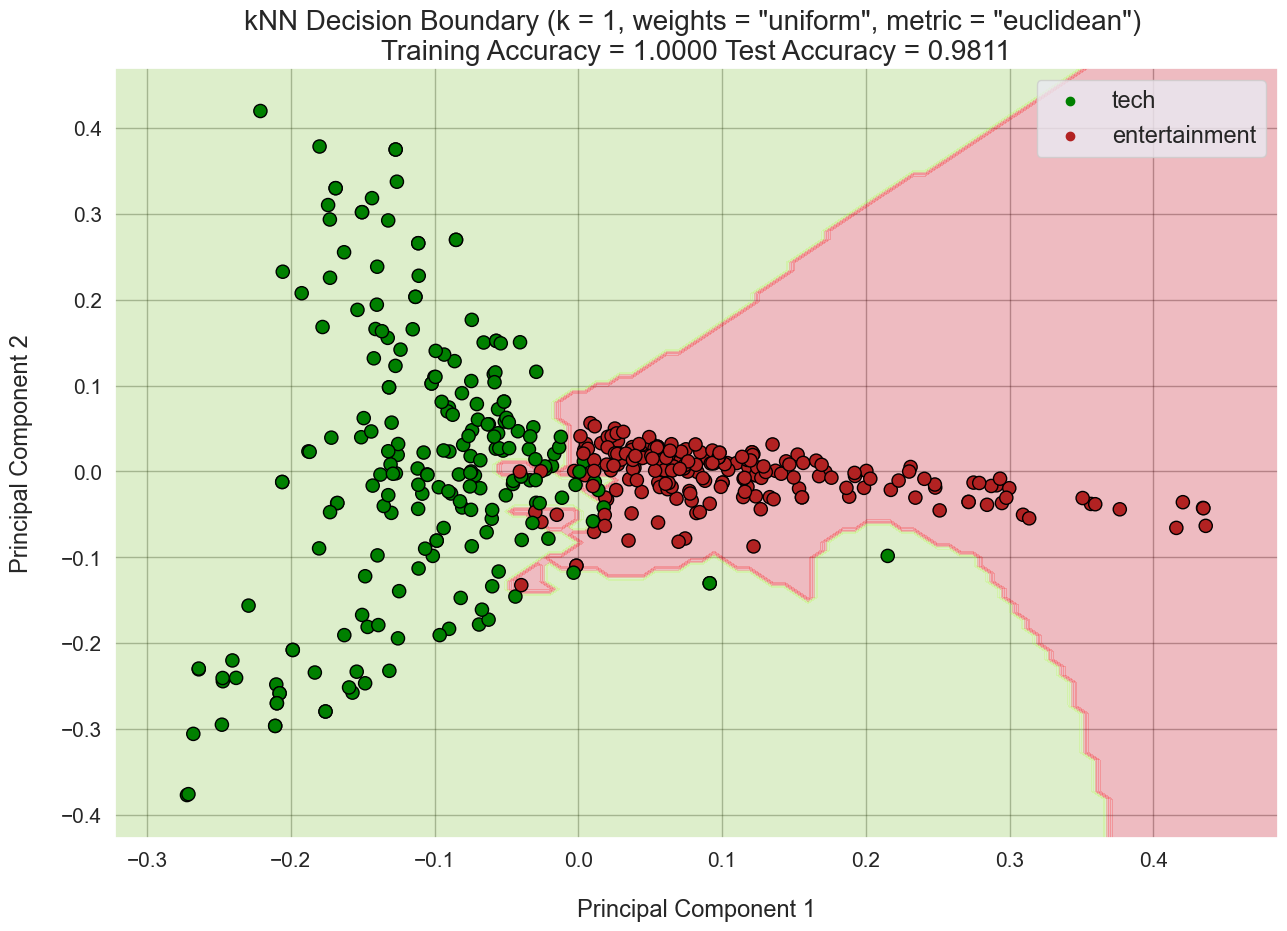

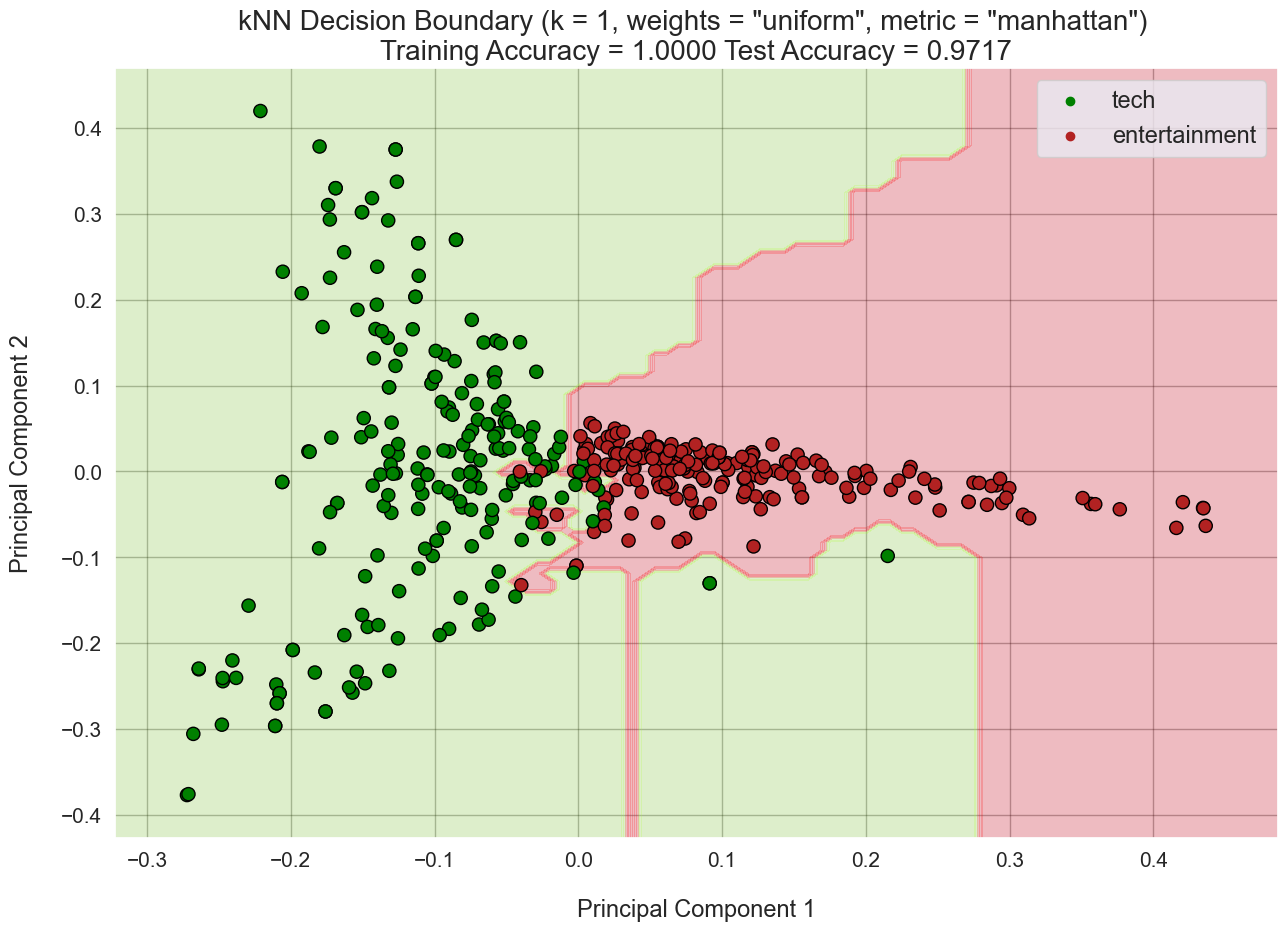

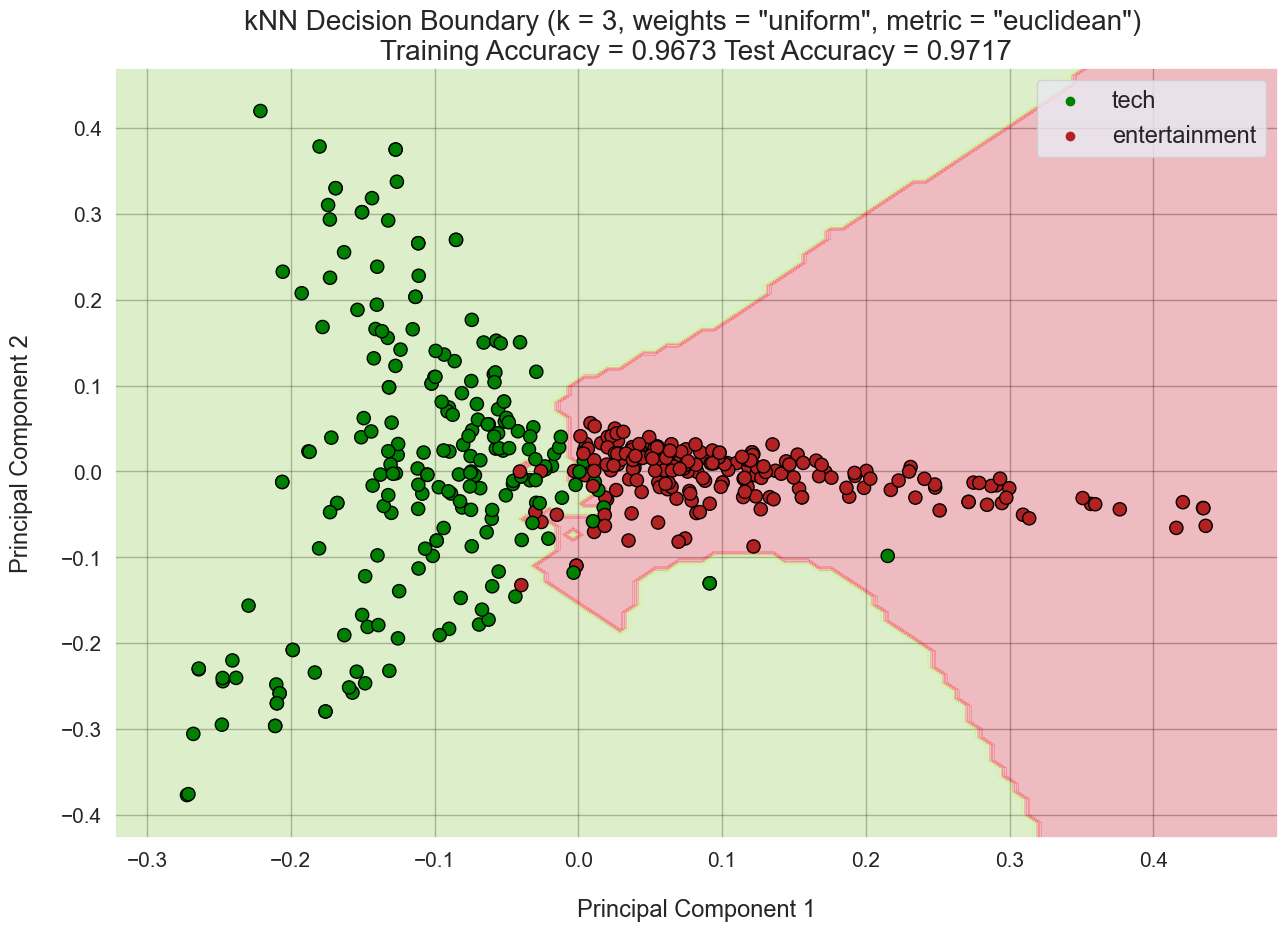

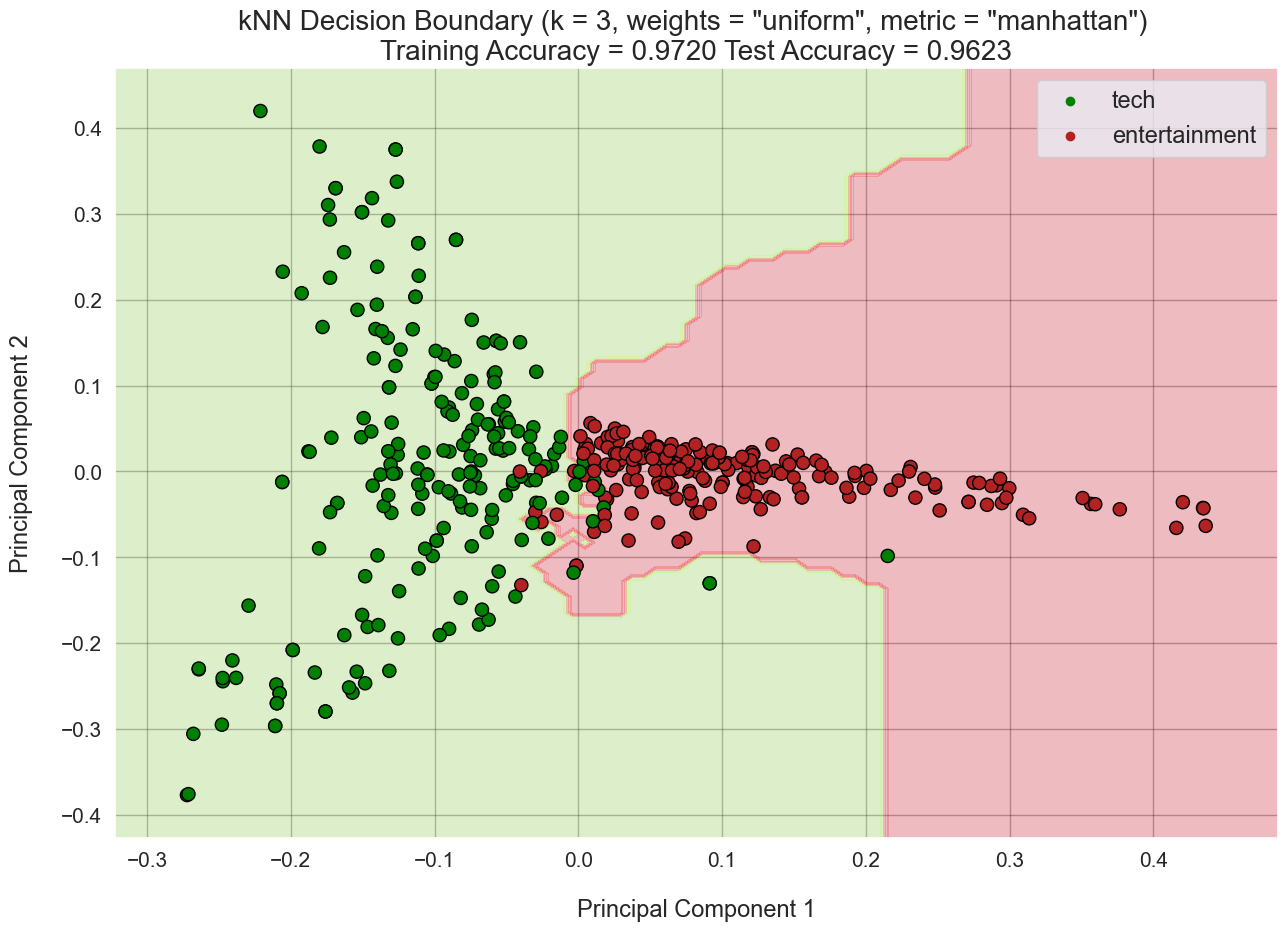

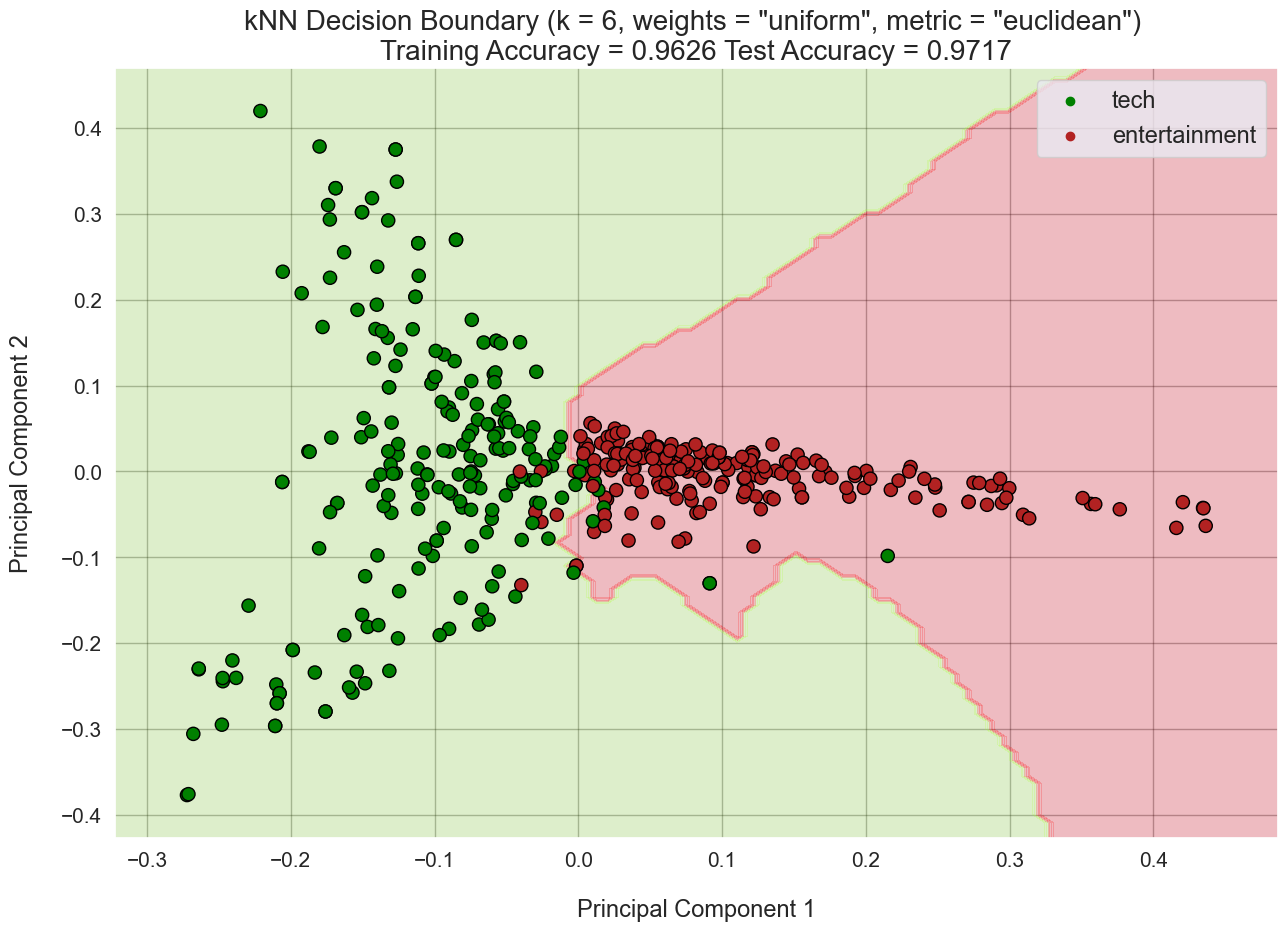

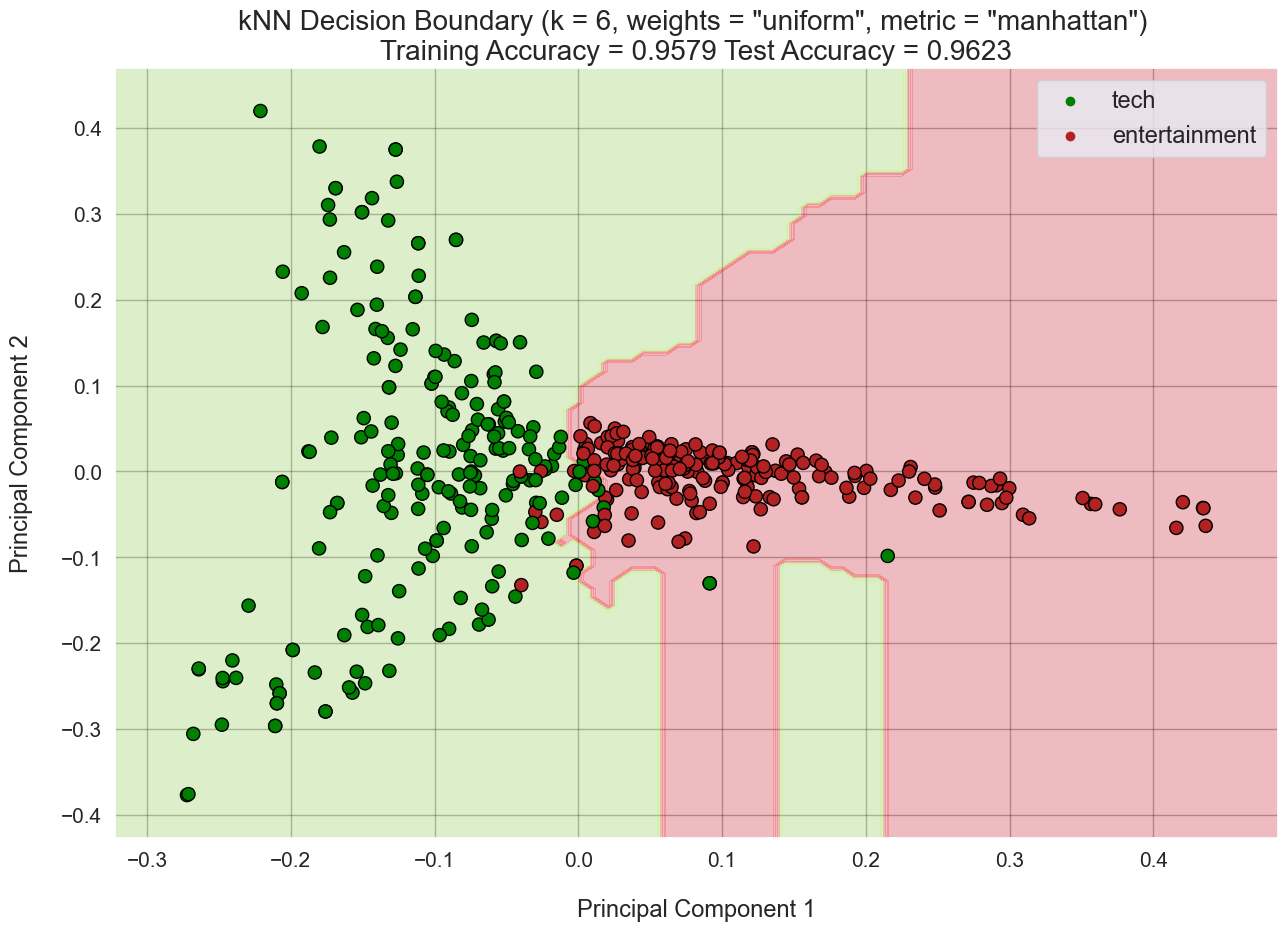

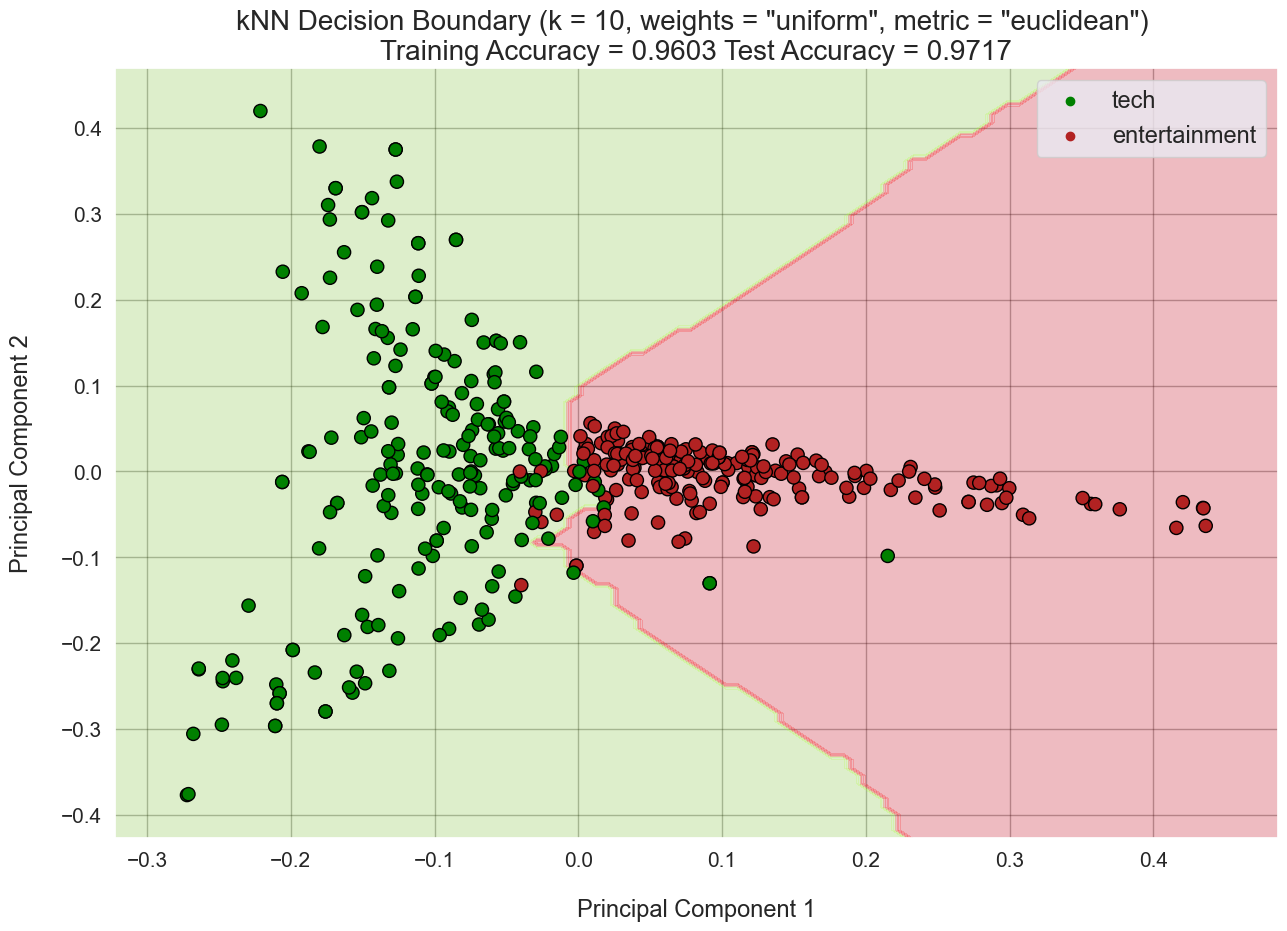

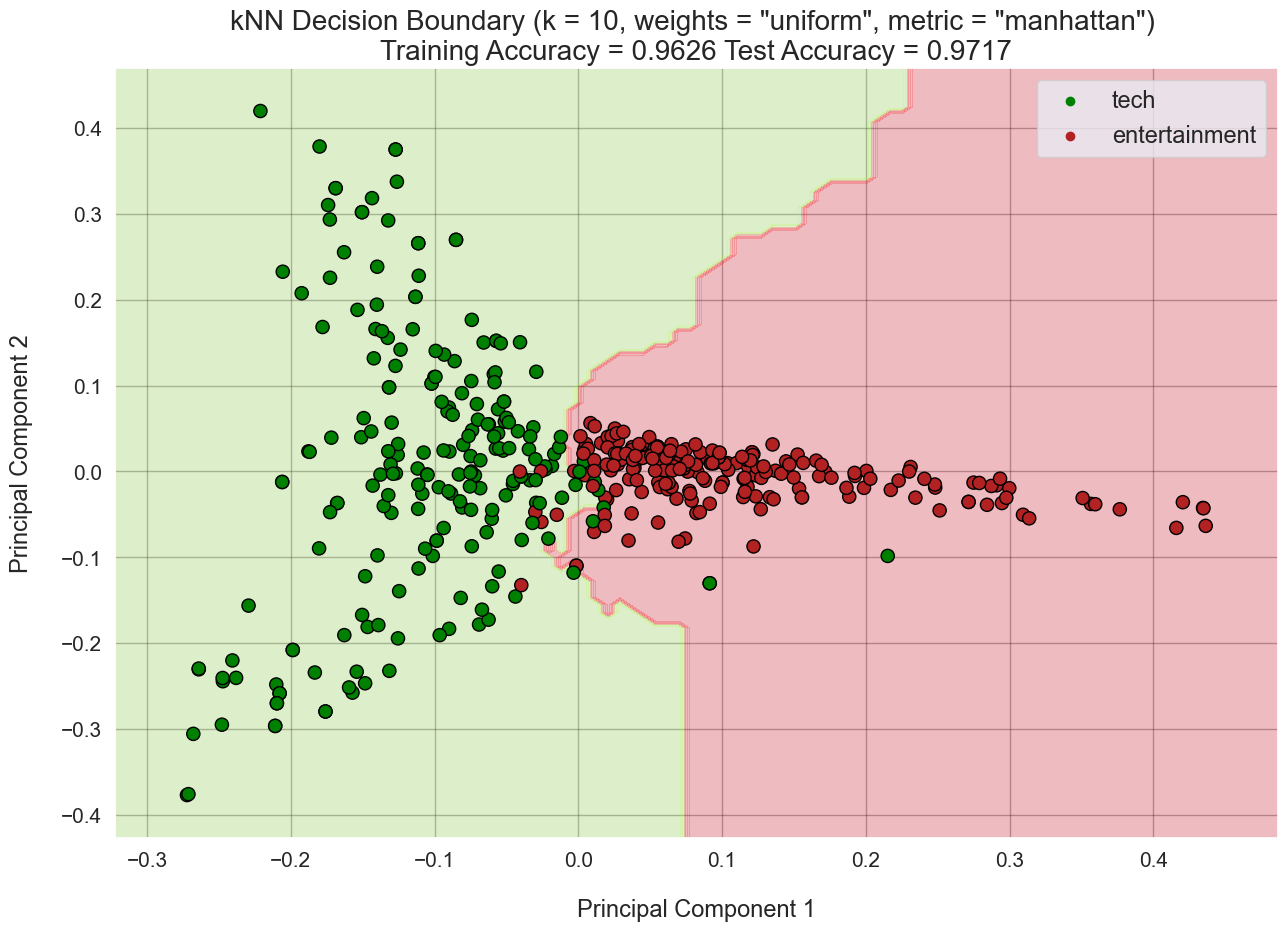

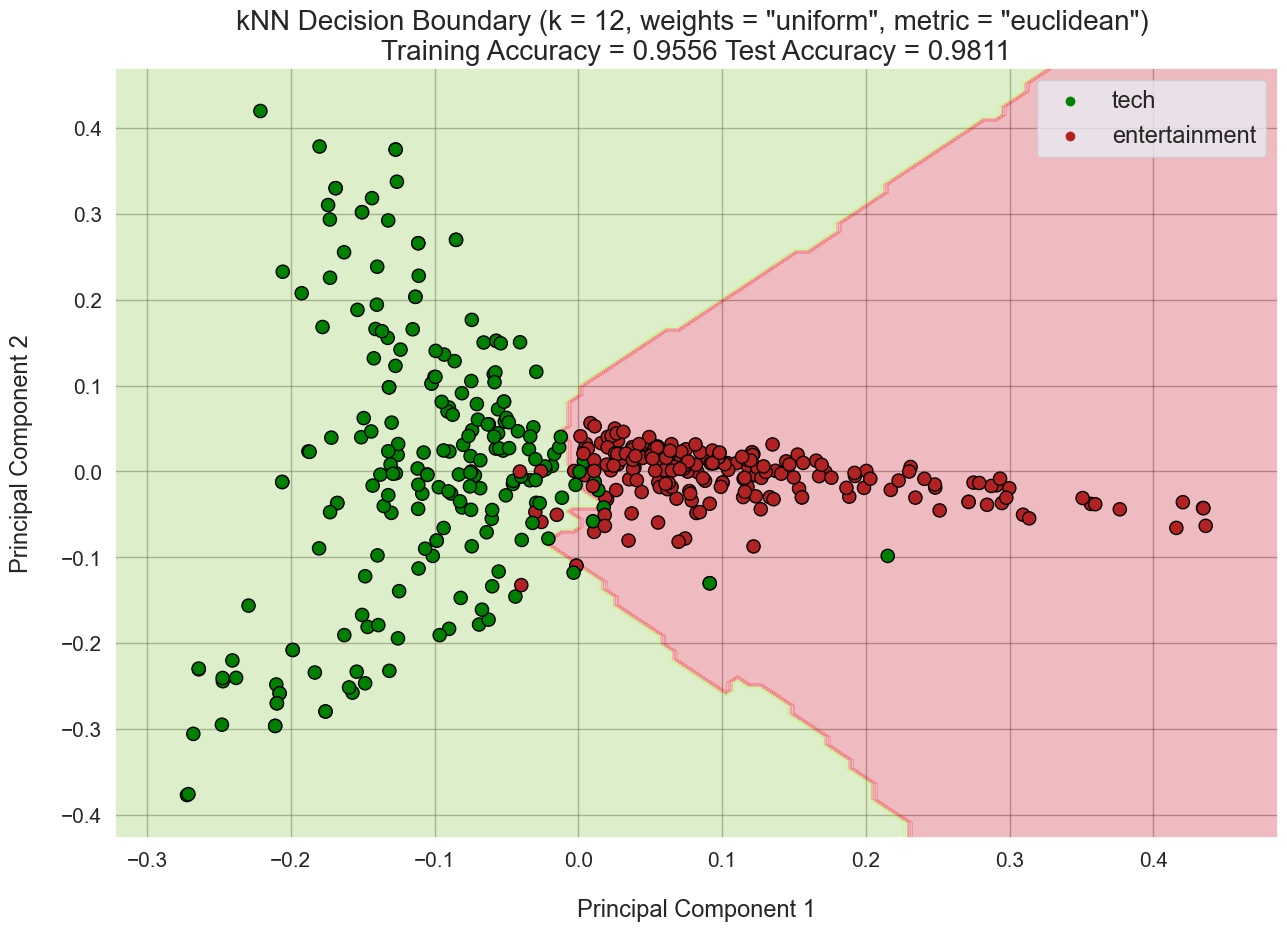

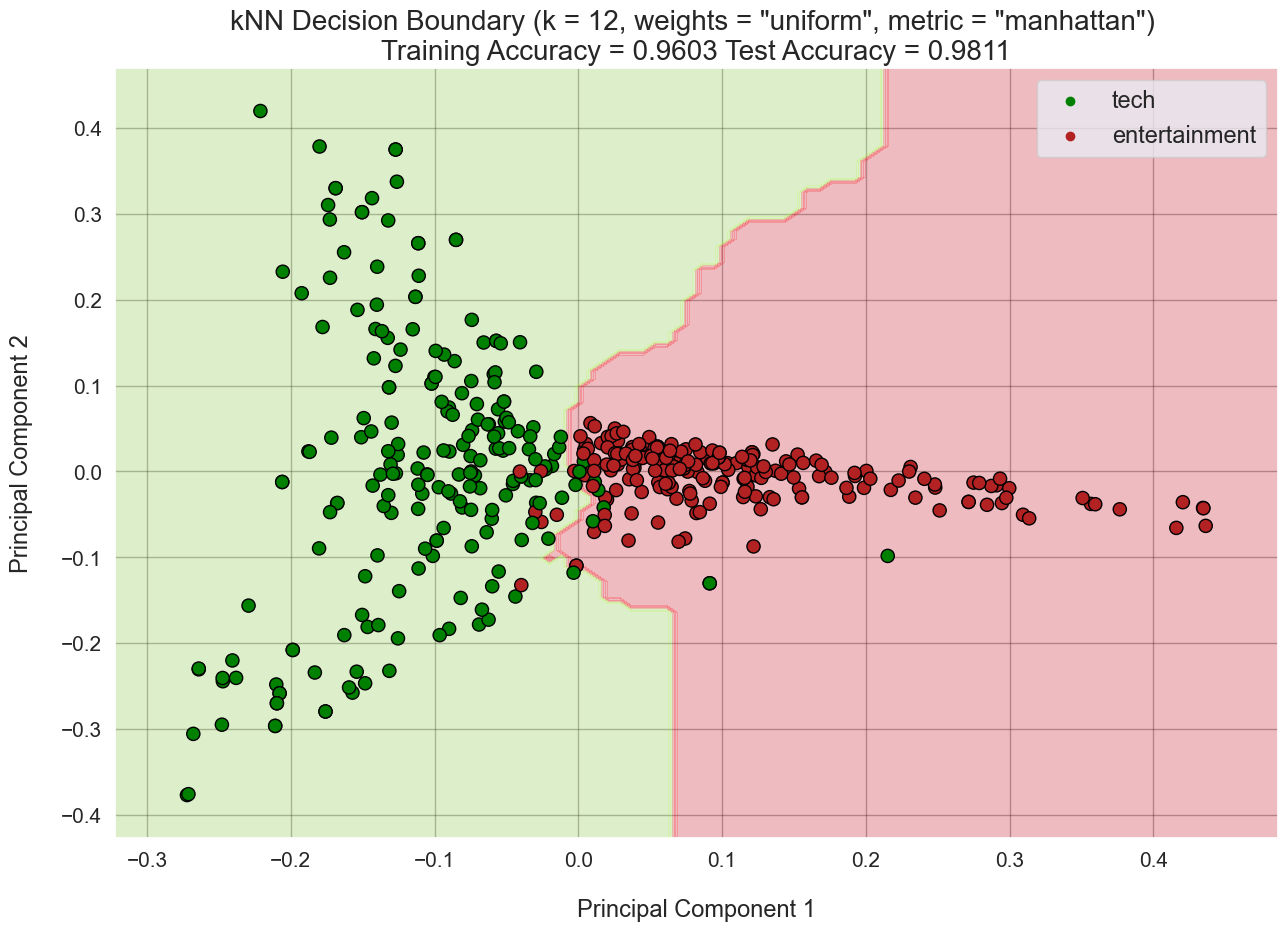

In [6]:
from sklearn.neighbors import KNeighborsClassifier as knn
from matplotlib.colors import ListedColormap

#kNN without weighting by distance and using euclidean distance (after applying PCA)
pca = PCA(n_components = 2, random_state = 1)
pca = pca.fit(prep_X_train)
pca_X_train = pd.DataFrame(pca.transform(prep_X_train), index = prep_X_train.index, columns = \
                           ['PC1', 'PC2'])

pca_X_test = pd.DataFrame(pca.transform(prep_X_test), index = prep_X_test.index, columns = \
                          ['PC1', 'PC2'])

n_neighbors = [1, 3, 6, 10, 12]
for k in n_neighbors:
    training_acc = []
    scores = []
    #kNN using the Euclidean distance metric
    knnC = knn(n_neighbors = k, weights = 'uniform', metric = 'euclidean')
    knnC.fit(pca_X_train, Y_train)
    training_acc.append(knnC.score(pca_X_train, Y_train))
    scores.append(knnC.score(pca_X_test, Y_test))
    
    #kNN using the Manhattan distance metric
    knnC2 = knn(n_neighbors = k, weights = 'uniform', metric = 'manhattan')
    knnC2.fit(pca_X_train, Y_train)
    training_acc.append(knnC2.score(pca_X_train, Y_train))
    scores.append(knnC2.score(pca_X_test, Y_test))
    
    for i, clf in enumerate([knnC, knnC2]):
        #Plotting the decision boundaries
        plt.rcParams['figure.figsize'] = (15, 10)
        cmap_light = ListedColormap(['greenyellow', 'red'])
        _, ax = plt.subplots()
        DecisionBoundaryDisplay.from_estimator(clf, pca_X_train, response_method = 'predict', alpha = 0.2, \
                            cmap = cmap_light, ax = ax, eps = 0.05)
        knn_plot = sns.scatterplot(x = pca_X_train['PC1'], y = pca_X_train['PC2'], hue = Y_train, \
                            palette = ['green','firebrick'], edgecolor = 'black', s = 90, linewidth = 1)
        knn_plot.set_title('kNN Decision Boundary (k = {}, weights = "{}", metric = "{}") \
\nTraining Accuracy = {:.4f} Test Accuracy = {:.4f}' \
            .format(clf.n_neighbors, clf.weights, clf.metric, training_acc[i], scores[i]), fontsize = '20')
        plt.xlabel('Principal Component 1', fontsize = 17, labelpad = 20)
        plt.ylabel('Principal Component 2', fontsize = 17, labelpad = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        legend_names = {0: 'tech', 1: 'entertainment'}
        handles, _ = plt.gca().get_legend_handles_labels()
        plt.legend(handles, [legend_names.get(label, label) for label in np.unique(Y_train)], fontsize = '17')
        plt.grid(color = 'black', alpha = 0.3)
        plt.show()

PCA was the dimensionality reduction method of choice since selecting only 2 specific features (from the list of over 13000 features/words) wouldn't be sufficient in reflecting the effects of the hyperparameters k and distance metric. By using PCA to transform the original features into a new set of orthogonal features (principal components) it becomes much easier to visualise and interpret the data and patterns while still making use of the large number of features instead of just picking 2 features and removing all the others.

**The impact of k on the decision boundary** is that for smaller values of k, the decision boundary was more jagged due to the resulting model being more sensitive to local patterns/changes. As a result of this higher sensitivity to local patterns, the red decision region/area (entertainment label) for the smaller k values is also smaller than when the k values are larger. This also ties into the fact that for smaller k values the decision boundary is more easily affected by outliers and as we can see in the plots there are 2 green tech labelled points, that could be considered outliers, that are closer to the red entertainment grouping than the green tech grouping which is causing the green decision area to expand while shrinking the red decision area when a small k value is used (thus shifting the decision boundary towards the right hand/red side). Inversely, for larger values of k the decision boundary is smoother and less affected by the 2 aforementioned outlier points. However the downside of larger k values is that local patterns aren't captured as accurately especially in the middle of the plots shown where the 2 classes meet and overlap a bit.

**The impact of the distance metric** is that when using Euclidean distance the decision boundary is more smooth and cone shaped compared to when using the Manhattan distance which is more jagged and less of a cone shape. The Euclidean distance decision boundary follows the contours of the data distribution and expands outwards from the dense regions and the Manhattan distance decision boundary is more aligned with the axes (since instead of measuring the distance between 2 points directly using a straight line like Euclidean distance, it measures the distance between 2 points by axis e.g. |x<sub>2</sub> - x<sub>1</sub>| + |y<sub>2</sub> - y<sub>1</sub>|).

# Task 3b) kNN (task 3b is done before 3a to get best model first)

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

n_neighbors = [1, 3, 6, 10, 12, 15, 18]
#n_neighbors = [11, 12, 13, 14]
#n_neighbors = [12, 2, 4, 5, 7, 8, 9]
best_test_score = 0
best_cv_score = 0
best_train_score = 0
best_clf = None
ue_scores = []    #uniform Euclidean scores
de_scores = []    #distance Euclidean scores
um_scores = []    #uniform Manhattan scores
dm_scores = []    #distance Manhattan scores
for k in n_neighbors:
    clfs = []
    #kNN using the Euclidean distance metric
    knnC = knn(n_neighbors = k, weights = 'uniform', metric = 'euclidean')
    knnC.fit(prep_X_train, Y_train)
    clfs.append(knnC)
    
    #kNN using the Euclidean distance metric weighted by distance
    knnCd = knn(n_neighbors = k, weights = 'distance', metric = 'euclidean')
    knnCd.fit(prep_X_train, Y_train)
    clfs.append(knnCd)
    
    #kNN using the Manhattan distance metric
    knnC2 = knn(n_neighbors = k, weights = 'uniform', metric = 'manhattan')
    knnC2.fit(prep_X_train, Y_train)
    clfs.append(knnC2)
    
    #kNN using the Manhattan distance metric weighted by distance
    knnCd2 = knn(n_neighbors = k, weights = 'distance', metric = 'manhattan')
    knnCd2.fit(prep_X_train, Y_train)
    clfs.append(knnCd2)

    for clf in clfs:
        cv_scores = cross_val_score(clf, prep_X_train, Y_train, cv = 5, scoring = 'f1') #5-fold cross-validation
        average_cv_score = np.mean(cv_scores)
        train_preds = clf.predict(prep_X_train)
        test_preds = clf.predict(prep_X_test)
        train_score = f1_score(Y_train, train_preds)
        test_score = f1_score(Y_test, test_preds)
        
        if (clf.weights == 'uniform') & (clf.metric == 'euclidean'):
            ue_scores.append(test_score)
        if (clf.weights == 'distance') & (clf.metric == 'euclidean'):
            de_scores.append(test_score)
        if (clf.weights == 'uniform') & (clf.metric == 'manhattan'):
            um_scores.append(test_score)
        if (clf.weights == 'distance') & (clf.metric == 'manhattan'):
            dm_scores.append(test_score)
        
        
        print('For k = {}, weights = "{}", Distance metric = "{}" \nTraining F1-score = {:.4f}, \
        \nAverage CV F1-score = {:.4f}, \nTest F1-score = {:.4f}\n'\
        .format(clf.n_neighbors, clf.weights, clf.metric, train_score, average_cv_score, test_score))
        if average_cv_score > best_cv_score:
            best_test_score = test_score
            best_cv_score = average_cv_score
            best_train_score = train_score
            best_clf = clf
        elif (average_cv_score == best_cv_score) & (test_score > best_test_score):
            best_test_score = test_score
            best_cv_score = average_cv_score
            best_train_score = train_score
            best_clf = clf

print('The best kNN model has k = {}, weights = "{}", metric = "{}" with: \nTraining F1-score = {:.4f}\n\
Average Cross-Validation F1-score = {:.4f}\nTest F1-score = {:.4f}'\
      .format(best_clf.n_neighbors, best_clf.weights, best_clf.metric, best_train_score, best_cv_score, best_test_score))

For k = 1, weights = "uniform", Distance metric = "euclidean" 
Training F1-score = 1.0000,         
Average CV F1-score = 0.9422, 
Test F1-score = 0.9483

For k = 1, weights = "distance", Distance metric = "euclidean" 
Training F1-score = 1.0000,         
Average CV F1-score = 0.9422, 
Test F1-score = 0.9483

For k = 1, weights = "uniform", Distance metric = "manhattan" 
Training F1-score = 1.0000,         
Average CV F1-score = 0.9023, 
Test F1-score = 0.9365

For k = 1, weights = "distance", Distance metric = "manhattan" 
Training F1-score = 1.0000,         
Average CV F1-score = 0.9023, 
Test F1-score = 0.9365

For k = 3, weights = "uniform", Distance metric = "euclidean" 
Training F1-score = 0.9785,         
Average CV F1-score = 0.9566, 
Test F1-score = 0.9748

For k = 3, weights = "distance", Distance metric = "euclidean" 
Training F1-score = 1.0000,         
Average CV F1-score = 0.9566, 
Test F1-score = 0.9748

For k = 3, weights = "uniform", Distance metric = "manhattan" 
Trai

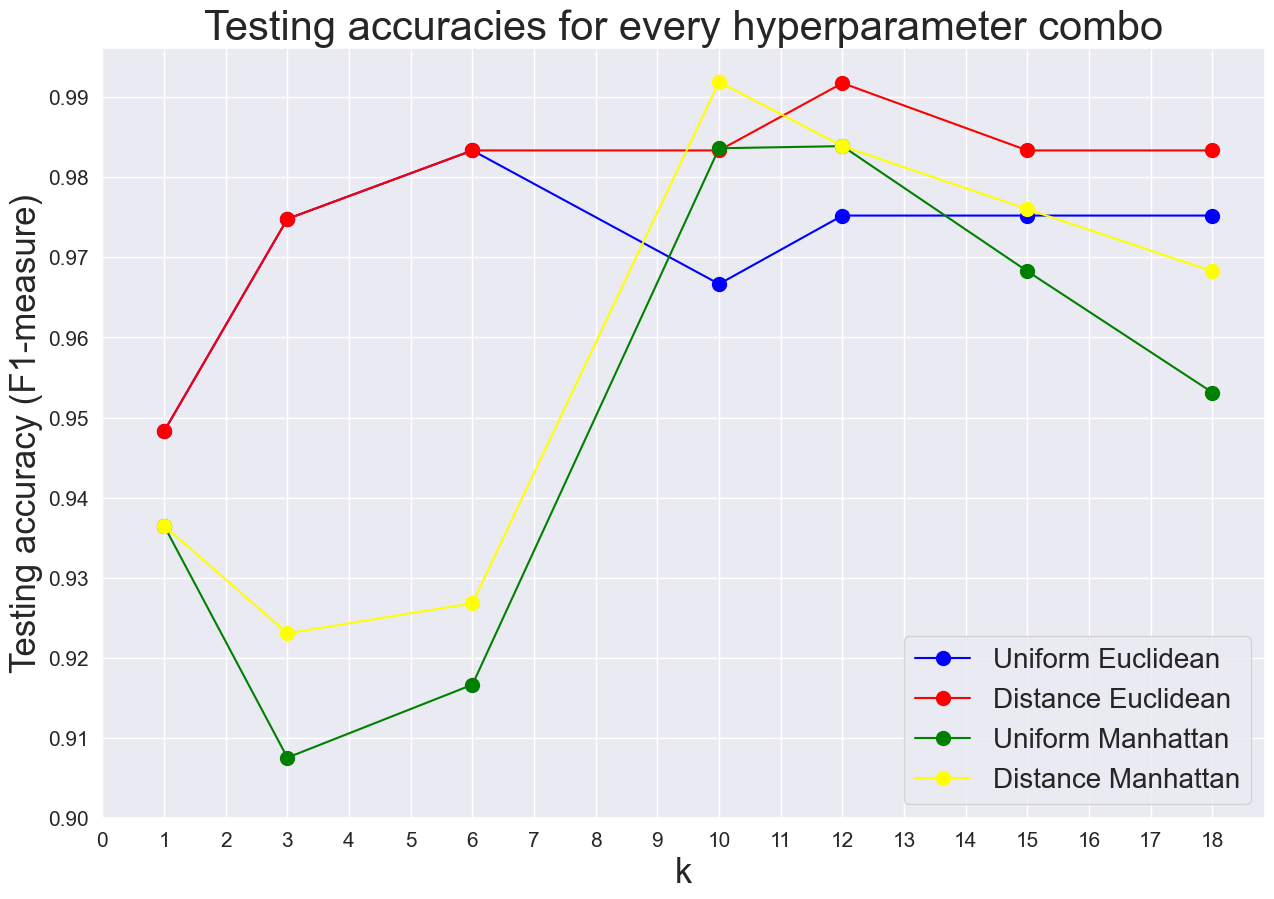

In [9]:
#lineplot showing the testing accuracies of the weights/metric hyperparameter combos for each value of k
plt.rcParams['figure.figsize'] = (15, 10)

plt.plot(n_neighbors, ue_scores, marker='o', markersize = 10, color='blue', label = 'Uniform Euclidean') 
plt.plot(n_neighbors, de_scores, marker='o', markersize = 10, color='red', label = 'Distance Euclidean') 
plt.plot(n_neighbors, um_scores, marker='o', markersize = 10, color='green', label = 'Uniform Manhattan') 
plt.plot(n_neighbors, dm_scores, marker='o', markersize = 10, color='yellow', label = 'Distance Manhattan') 
plt.title('Testing accuracies for every hyperparameter combo', fontsize = 30)
plt.xlabel('k', fontsize = 25)
plt.ylabel('Testing accuracy (F1-measure)', fontsize = 25)
plt.xticks(range(19), fontsize = 15)
plt.yticks(np.arange(0.9, 1, 0.01), fontsize = 15)
plt.legend(loc = 'lower right', fontsize = 20)
plt.show()

Cross-validation was used on kNN models with every combination of the following hyperparameter values:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-**k** = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-**weights** = uniform, distance\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-**metric** = euclidean, manhattan

For the **k** hyperparameter, the testing accuracy steadily improves as k increases when it's used alongside the **Euclidean distance metric** before peaking at k = 12. For k values larger than the peak, the testing accuracy decreases slightly or hits a wall/plateaus, and essentially stops changing. As k increases while used alongside the **Manhattan distance metric**, the testing accuracy starts decreasing at first until k = 3 where it's at it's minimum before increasing and peaking (at k = 12 for uniform weights, k = 10 for distance weights). So for the k hyperparameter the testing accuracy is highest when it's around a medium size, not too small or too large.

For the **distance metric** hyperparameter, the testing accuracy is impacted by whether **Euclidean** or **Manhattan** is chosen. For this dataset the **Euclidean distance metric** overall more consistently gives higher testing accuracy compared to the **Manhattan distance metric**. 

The **weights** hyperparameter also seems to have a significant/noticeable impact on the testing accuracy. When **distance-weighting** is used (assign weights to each neighbor based on their distance to x'), the testing accuracy is higher for most cases compared to when **no distance-weighting (uniform)** is used. This is especially the case when comparing the weights within the same **distance metric** hyperparameter (e.g. Uniform Euclidean & Distance Euclidean, Uniform Manhattan & Distance Manhattan).

**The best model has k = 12, weights = "distance", and metric = "euclidean".**

# Task 3a) kNN

For portion 0.1:
Training F1-score = 1.0000
Test F1-score = 0.9483

For portion 0.3:
Training F1-score = 1.0000
Test F1-score = 0.9836

For portion 0.5:
Training F1-score = 1.0000
Test F1-score = 0.9836

For portion 0.7:
Training F1-score = 1.0000
Test F1-score = 0.9833

For portion 0.9:
Training F1-score = 1.0000
Test F1-score = 0.9917



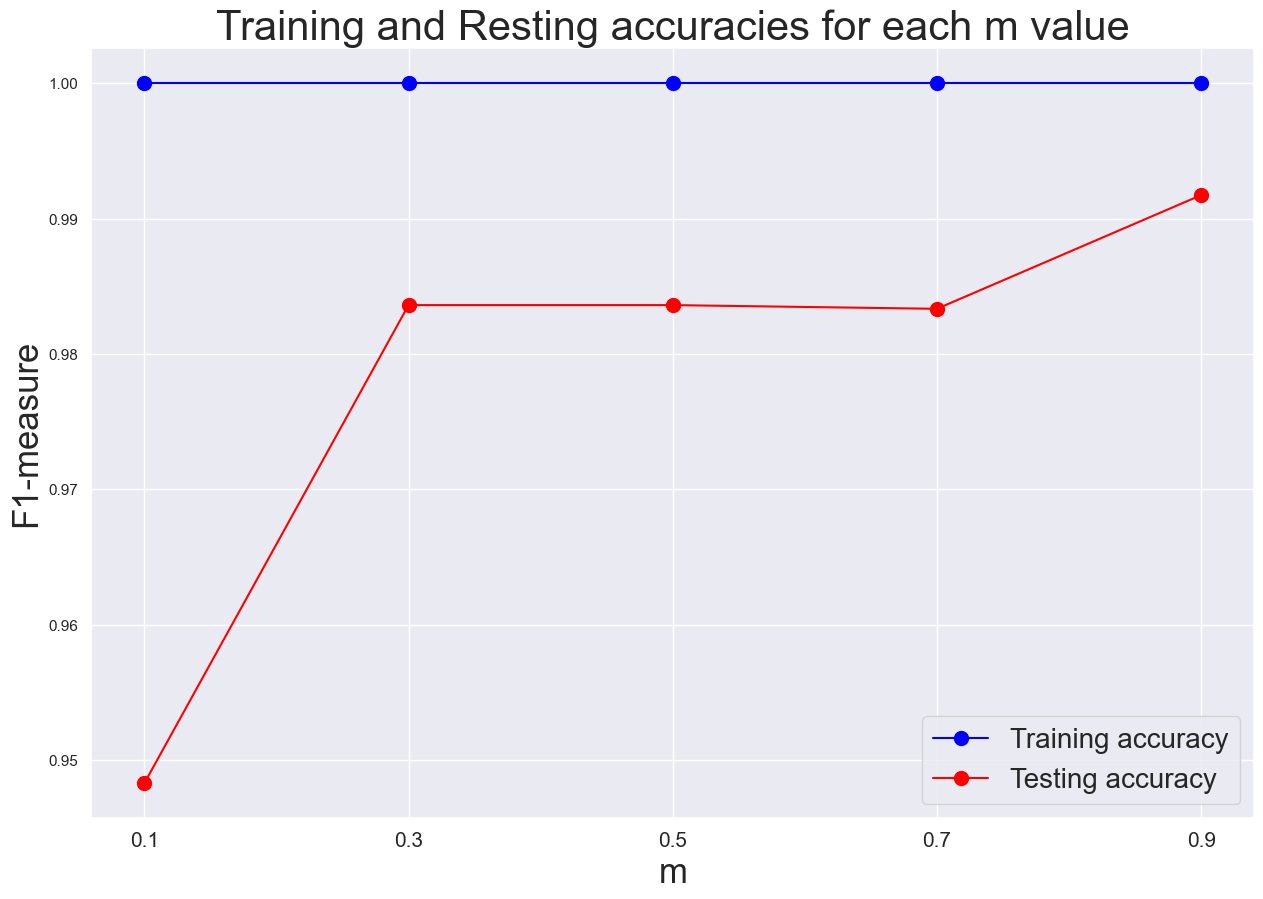

In [10]:
m = [0.1, 0.3, 0.5, 0.7, 0.9]
train_scores = []
test_scores = []
for M in m:
    MN = round(M * prep_X_train.shape[0])
    knn_clf = knn(n_neighbors = 12, weights = 'distance', metric = 'euclidean')
    knn_clf.fit(prep_X_train.iloc[0:MN - 1], Y_train.iloc[0:MN - 1]) #MN - 1 since the index starts at 0
    train_preds = knn_clf.predict(prep_X_train.iloc[0:MN - 1])
    test_preds = knn_clf.predict(prep_X_test)
    
    train_score = f1_score(Y_train.iloc[0:MN - 1], train_preds)
    train_scores.append(train_score)
    test_score = f1_score(Y_test, test_preds)
    test_scores.append(test_score)
    print('For portion {}:\nTraining F1-score = {:.4f}\nTest F1-score = {:.4f}\n'.format(M, train_score, test_score))
    
'''
plt.plot(m, train_scores, marker='o', markersize = 10, color='red')  
plt.title('Training accuracies for each m value', fontsize = 30)
plt.xlabel('m', fontsize = 25)
plt.ylabel('F1-measure', fontsize = 25)
plt.xticks(m, fontsize = 15)
plt.show()

plt.plot(m, test_scores, marker='o', markersize = 10, color='blue') 
plt.title('Testing accuracies for each m value', fontsize = 30)
plt.xlabel('m', fontsize = 25)
plt.ylabel('F1-measure', fontsize = 25)
plt.xticks(m, fontsize = 15)
plt.show()
'''
plt.plot(m, train_scores, marker='o', markersize = 10, color = 'blue', label = 'Training accuracy') 
plt.plot(m, test_scores, marker='o', markersize = 10, color = 'red', label = 'Testing accuracy') 
plt.title('Training and Resting accuracies for each m value', fontsize = 30)
plt.xlabel('m', fontsize = 25)
plt.ylabel('F1-measure', fontsize = 25)
plt.xticks(m, fontsize = 15)
plt.legend(loc = 'lower right', fontsize = 20)
plt.show()

The training accuracies for each portion *m* were all 100%. The testing accuracies generally increased as the size of *m* grew.

In [11]:
#kNN with best hyperparameter settings
best_knn = knn(n_neighbors = 12, weights = 'distance', metric = 'euclidean')
best_knn.fit(prep_X_train, Y_train)

knn_preds = best_knn.predict(prep_X_test)
knn_score = f1_score(Y_test, knn_preds)
print(knn_score)

0.9917355371900827
